In [6]:
import cv2
import numpy as np
from pathlib import Path

In [7]:
# Path to video file
video_path = Path("data/videos/test_video.mp4")

# Initialize video capture
cap = cv2.VideoCapture(str(video_path))

if not cap.isOpened():
    raise ValueError(f"Cannot open video: {video_path}")

In [8]:
# Create background subtractor
# MOG2 is good for varying lighting, KNN is better for shadows
bg_subtractor = cv2.createBackgroundSubtractorMOG2(
    history=500,        # number of frames for background model
    varThreshold=16,    # threshold for foreground detection
    detectShadows=True  # detect shadows (marked as gray)
)

# Alternative: KNN-based subtractor
# bg_subtractor = cv2.createBackgroundSubtractorKNN(
#     history=500,
#     dist2Threshold=400.0,
#     detectShadows=True
# )

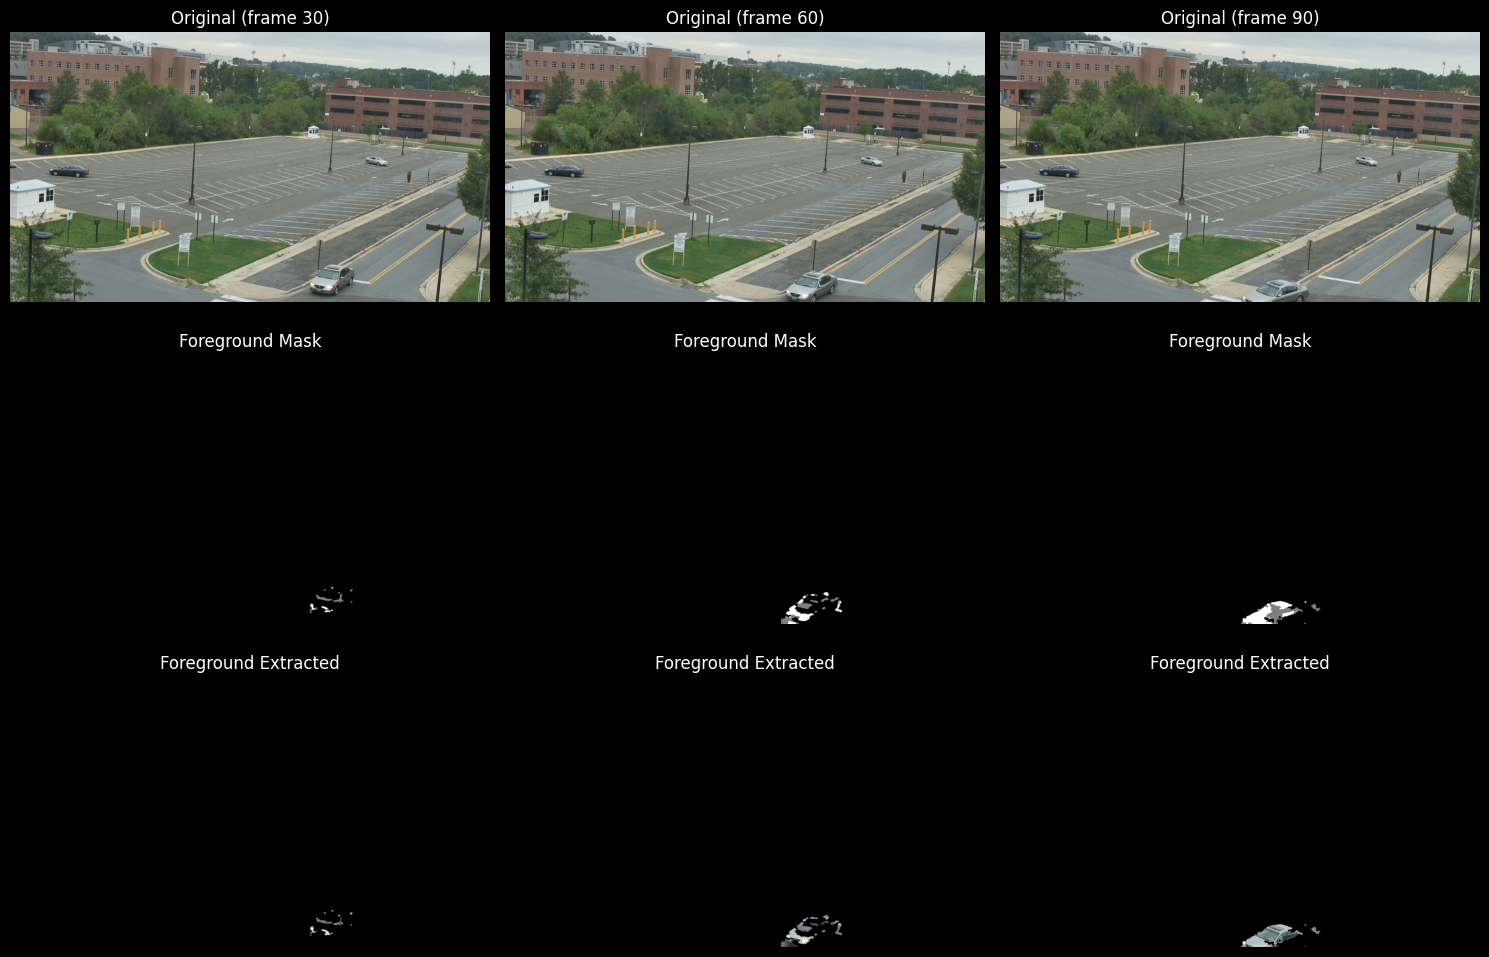

Processed and saved 2114 frames
Frames saved to: C:\Motion-detection\data\frames
Masks saved to: C:\Motion-detection\data\masks


In [9]:
import matplotlib.pyplot as plt

# Create output directories
output_dir = Path("data")
frames_dir = output_dir / "frames"
masks_dir = output_dir / "masks"
frames_dir.mkdir(parents=True, exist_ok=True)
masks_dir.mkdir(parents=True, exist_ok=True)

# Process video and save all frames
frame_count = 0
sample_interval = 30  # show every 30th frame for display
sample_frames = []

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame_count += 1
    
    # Apply background subtraction
    fg_mask = bg_subtractor.apply(frame)
    
    # Clean up the mask with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    fg_mask_clean = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
    fg_mask_clean = cv2.morphologyEx(fg_mask_clean, cv2.MORPH_CLOSE, kernel)
    
    # Save original frame and mask
    cv2.imwrite(str(frames_dir / f"frame_{frame_count:04d}.png"), frame)
    cv2.imwrite(str(masks_dir / f"mask_{frame_count:04d}.png"), fg_mask_clean)
    
    # Collect samples for display
    if frame_count % sample_interval == 0 and len(sample_frames) < 3:
        foreground = cv2.bitwise_and(frame, frame, mask=fg_mask_clean)
        sample_frames.append((frame_count, frame, fg_mask_clean, foreground))

cap.release()

# Display sample frames
if sample_frames:
    fig, axes = plt.subplots(3, len(sample_frames), figsize=(15, 10))
    for idx, (fnum, frame, mask, fg) in enumerate(sample_frames):
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        foreground_rgb = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
        
        axes[0, idx].imshow(frame_rgb)
        axes[0, idx].set_title(f"Original (frame {fnum})")
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(mask, cmap='gray')
        axes[1, idx].set_title("Foreground Mask")
        axes[1, idx].axis('off')
        
        axes[2, idx].imshow(foreground_rgb)
        axes[2, idx].set_title("Foreground Extracted")
        axes[2, idx].axis('off')
    
    plt.tight_layout()
    plt.show()

print(f"Processed and saved {frame_count} frames")
print(f"Frames saved to: {frames_dir.absolute()}")
print(f"Masks saved to: {masks_dir.absolute()}")